In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sys

sys.path.append("/home/truggles/Inter-annual_Variability_Residual_Load")
from helpers import return_file_info_map

In [2]:
def get_temp_file(ba):
    ba_info = return_file_info_map( ba )
    df = pd.read_csv(f"../{ba_info['temp'][0]}")
    df['yr_local'] = df['year'].shift(periods=-1*ba_info['to_local'])
    df['hr_local'] = df['hour'].shift(periods=-1*ba_info['to_local'])
    df['day_local'] = df['day'].shift(periods=-1*ba_info['to_local'])
    df = df.loc[ (df['yr_local'] >= ba_info['years'][0]) & (df['year'] <= ba_info['years'][-1]) ]
    df = df.reset_index()
    df = df.drop(['index',], axis=1)
    #print(df.head(10))
    return df

def get_demand_file(ba):

    ba_info = return_file_info_map( ba )
    df = pd.read_csv(f"../{ba_info['demand'][0].replace('.csv', '_expDT.csv')}")
    df['yr_local'] = df['year'].shift(periods=-1*ba_info['to_local'])
    df['hr_local'] = df['hour'].shift(periods=-1*ba_info['to_local'])
    df['day_local'] = df['day'].shift(periods=-1*ba_info['to_local'])
    df = df.loc[ (df['yr_local'] >= ba_info['years'][0]) & (df['year'] <= ba_info['years'][-1]) ]
    df = df.reset_index()
    df = df.drop(['index',], axis=1)
    df = demand_normalize_annual_mean(ba, df)
    #print(df.head(10))
    return df

def demand_normalize_annual_mean(ba, dem):
    ba_info = return_file_info_map( ba )
    years = ba_info['years']
    
    ary = np.zeros(0)
    for yr in years:
        df = dem.loc[ dem['year'] == yr ]
        norm = df['demand (MW)'] # / np.nanmean(df['demand (MW)']) # no more annual normailzation with exponential detrending
        ary = np.append(ary, norm)
    dem['normalized demand'] = ary
    return dem

def analyze(ba, dy):
    ba_info = return_file_info_map( ba )
    years = ba_info['years']
    
    corrs = []
    
    for yr in years:
        t = dy.loc[ dy['year'] == yr ]
        tgt = t[['CDD_nan', 'pk_dem']]
        corr = tgt.corr()
        corrs.append(corr.loc['CDD_nan', 'pk_dem'])
    return corrs

def calc_daily_values(dem, temp, HDD_base, CDD_base, demand='normalized demand'):
    yrs = []
    months = []
    days = []
    day_pk_dem = []
    day_min_temp = []
    day_max_temp = []
    day_avg_temp = []
    day_HDD = []
    day_CDD = []
    
    pk_dem = -99.
    min_temp = 99.
    max_temp = -99.
    avg_temp = 0.
    
    # Ensure datetime is aligned
    # b/c we ensure they are aligned, we can use iloc and enumerate over them.
    assert(dem['hr_local'].all() == temp['hr_local'].all())
    assert(dem['day_local'].all() == temp['day_local'].all())
    assert(dem['yr_local'].all() == temp['yr_local'].all())
    
    for i, _ in enumerate(dem.index):
        #if i == 0:
        #    print(i, dem.iloc[idx])
        #    print(i, temp.iloc[idx])
        if dem.iloc[i]['hr_local'] == 24:
            day_pk_dem.append(pk_dem)
            pk_dem = -99.
            
            yrs.append(dem.iloc[i]['year'])
            months.append(dem.iloc[i]['month'])
            days.append(dem.iloc[i]['day'])
            
            day_min_temp.append(min_temp)
            day_max_temp.append(max_temp)
            day_avg_temp.append(avg_temp/24.)
            min_temp = 99.
            max_temp = -99.
            avg_temp = 0.
            
        else:
            if dem.iloc[i][demand] > pk_dem:
                pk_dem = dem.iloc[i][demand]
            
            avg_temp += temp.iloc[i]['temp']
            if temp.iloc[i]['temp'] > max_temp:
                max_temp = temp.iloc[i]['temp']
            if temp.iloc[i]['temp'] < min_temp:
                min_temp = temp.iloc[i]['temp']

    df = pd.DataFrame({
        'year':yrs,
        'month':months,
        'day':days,
        'pk_dem':day_pk_dem,
        'min_temp':day_min_temp,
        'max_temp':day_max_temp,
        'avg_temp':day_avg_temp
    })
    # "Mean"-based
    #df['HDD'] = HDD_base - (df['min_temp'] + df['max_temp'])/2.
    #df['HDD'] = np.where(df['HDD'] > 0., df['HDD'], 0.)
    df['CDD'] = (df['min_temp'] + df['max_temp'])/2. - CDD_base
    df['CDD_nan'] = np.where(df['CDD'] > 0., df['CDD'], np.nan)
    
    # Avg based
    #df['HDD_alt'] = HDD_base - df['avg_temp']
    #df['HDD_alt'] = np.where(df['HDD_alt'] > 0., df['HDD_alt'], 0.)
    df['CDD_alt'] = df['avg_temp'] - CDD_base
    df['CDD_alt_nan'] = np.where(df['CDD_alt'] > 0., df['CDD_alt'], np.nan)
    
    return df

In [3]:
BAs = ['ERCOT', 'NYISO', 'PJM', 'FR']
N_YEARS = 10

all_corrs = []

dys = {}

for ba in BAs:
    print(ba)
    ba_info = return_file_info_map( ba )
    years = ba_info['years']
    
    years_to_use = []
    for i, y in enumerate(reversed(years)):
        if i < N_YEARS:
            years_to_use.append(y)
    years_to_use.sort()
    print(len(years_to_use), years_to_use)
    
    dem = get_demand_file(ba)
    temp = get_temp_file(ba)
    
    dem2 = dem.loc[ (dem['yr_local'] >= years_to_use[0]) & (dem['yr_local'] <= years_to_use[-1]) ]
    temp2 = temp.loc[ (temp['yr_local'] >= years_to_use[0]) & (temp['yr_local'] <= years_to_use[-1]) ]
    
    # No 2007 FR demand data, so drop 1 hr of temp data from 2007
    if ba == 'FR':
        temp3 = temp2.loc[ (temp['year'] >= 2008) ]
        #print(dem2.head())
        #print(temp3.head())
    else:
        temp3 = temp2
    
    print(len(dem2.index))
    print(len(temp3.index))
    
    dem2 = dem2.reset_index()
    temp3 = temp3.reset_index()
    
    dy = calc_daily_values(dem2, temp3, 18, 18)
    dys[ba] = dy


    corrs = analyze(ba, dy)
    all_corrs.append(corrs)

ERCOT
10 [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
87642
87642
NYISO
10 [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
87643
87643
PJM
10 [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
87643
87643
FR
10 [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
87671
87671


ERCOT
max 22.0
PJM
max 15.0
NYISO
max 15.0
FR
max 38.0


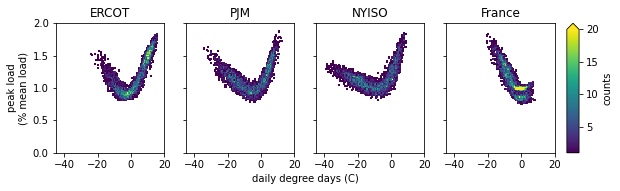

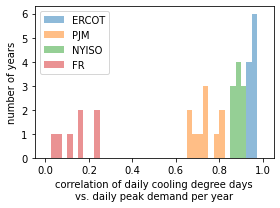

In [4]:

BAs = ['ERCOT', 'PJM', 'NYISO', 'FR']
fig, axs = plt.subplots(figsize=(8.5, 2.5), nrows=1, ncols=4, sharey=True, sharex=True)
outs = []
for i, ba in enumerate(BAs):
    print(ba)
    
    #axs[i].grid(linestyle='--', linewidth='0.5', color='gray')
    #axs[i].scatter(dys[ba]['CDD'], dys[ba]['pk_dem'], alpha=0.1)
    xmin = -45
    xmax = 20
    ymin = 0
    ymax = 2
    vmax_ = 20
    vmin_ = 1
    h, x, y, img = axs[i].hist2d(dys[ba]['CDD'], dys[ba]['pk_dem'], bins=100, range=[[xmin, xmax], [ymin, ymax]], vmin=vmin_, vmax=vmax_, cmin=1)
    print('max',np.nanmax(h))
    #axs[i].set_xlabel('daily degree days (C)')
    if i == 0:
        axs[i].set_ylabel('peak load\n(% mean load)')
    axs[i].set_xlim(-45,20)
    axs[i].xaxis.set_major_locator(matplotlib.ticker.FixedLocator([-40, -20, 0, 20, 40]))
    axs[i].set_ylim(0, 2.0)
    title = ba if ba != 'FR' else 'France'
    axs[i].set_title(title)
    #axs[i].axhline(0, color='gray', linewidth=1)

    if i + 1 == len(axs):
        fig.subplots_adjust(right=0.9)
        cbar_ax = fig.add_axes([0.92, 0.18, 0.02, 0.9-0.18])
        cbar = fig.colorbar(img, cax=cbar_ax, extend='max')
        cbar.ax.set_ylabel("counts")
        #dec = 0 
        #cbar.ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=100, decimals=dec))
    
# SHARED X AXIS LABEL
# https://stackoverflow.com/questions/16150819/common-xlabel-ylabel-for-matplotlib-subplots/53172335
# add a big axis, hide frame
ax = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax.set_xlabel('daily degree days (C)')

plt.subplots_adjust(left=0.085, bottom=0.18, top=0.9)
#plt.tight_layout()
plt.savefig(f'plots/ALL_degree_days_vs_pk_demand.pdf')



bins = np.arange(0.0, 1.01, 0.025)
fig, ax = plt.subplots(figsize=(4, 3))
for i, ba in enumerate(BAs):
    ax.hist(all_corrs[i], bins, label=BAs[i], alpha=0.5)
ax.set_xlabel('correlation of daily cooling degree days\nvs. daily peak demand per year')
ax.set_ylabel('number of years')
plt.legend()
plt.tight_layout()
plt.savefig(f'plots/degree_days_vs_pk_demand_corr.pdf')